###### 【問題1】公式Exampleを分担して実行
TensorFLowの公式Exampleを分担して実行してください。
以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

###### Neural Machine Translation with Attention

・翻訳では"sequence to sequence"という入力データを出力データへ変換する処理が行われる。（文全体から予測を行う）  
・seq2seqは２つのRNN (Enconder & Decoder)から構成される（RNNを使うのはワードの前後関係から予測を行うため）  
・Encoderで入力データをベクトルへ変換 => ベクトルをDecoderへ私し出力データを作成  
・以下の例ではattentionというロジックを追加し翻訳の精度を高めている。(encoderで算出された重み？によってdecoder側で関連の強いワードにattentionがかかる様にする)  

In [2]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.13.1


In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


データ前処理

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [ ]:
文字をベクトルへ置き換え

In [5]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [6]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [7]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [8]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

データセット

In [9]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [14]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [17]:
EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4758
Epoch 1 Batch 100 Loss 1.3615
Epoch 1 Batch 200 Loss 1.3432
Epoch 1 Batch 300 Loss 1.2505
Epoch 1 Loss 1.3335
Time taken for 1 epoch 1585.4686510562897 sec

Epoch 2 Batch 0 Loss 1.0041
Epoch 2 Batch 100 Loss 1.0037
Epoch 2 Batch 200 Loss 0.8377
Epoch 2 Batch 300 Loss 0.8596
Epoch 2 Loss 0.9260
Time taken for 1 epoch 1614.685038805008 sec



In [18]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [19]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [20]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [21]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


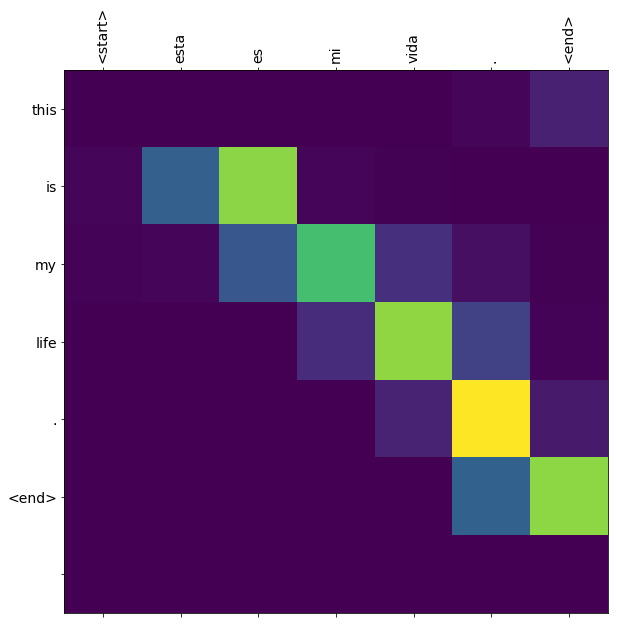

In [23]:
translate(u'esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> quiero ir a pescar . <end>
Predicted translation: i want to go fishing . <end> 


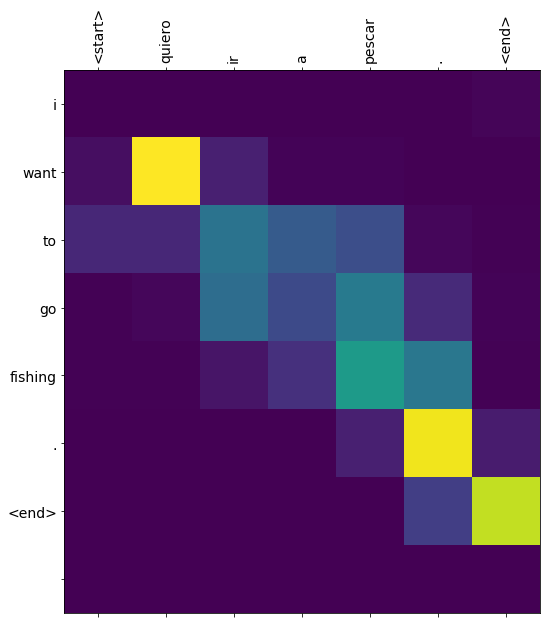

In [53]:
#I want to go fishing
translate(u'quiero ir a pescar.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> que hermoso dia hoy ! . <end>
Predicted translation: what s hot day ! <end> 


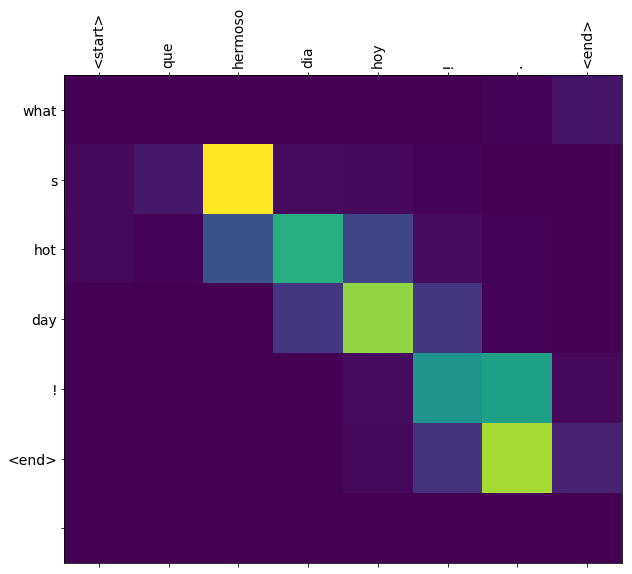

In [57]:
#What a beautiful day today!
translate(u'¡Qué hermoso día hoy!.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> creo que eso es lo que escribio ese chico . <end>
Predicted translation: i think that s weird . <end> 


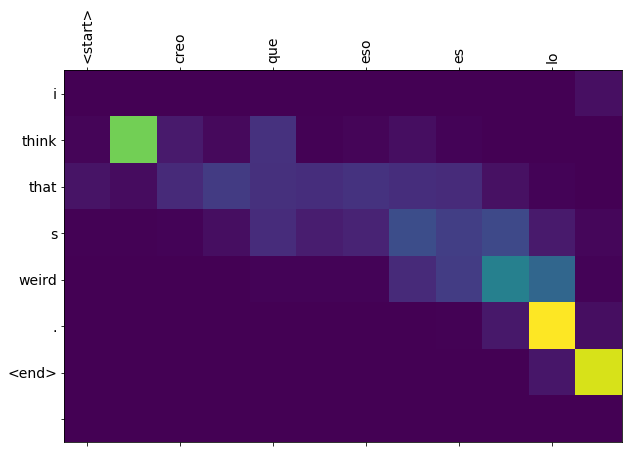

In [59]:
### I think that that that that that boy wrote is wrong.
translate(u'Creo que eso es lo que escribió ese chico.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

###### 【問題2】Iris（2値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する2値分類をKerasに書き換えてください。

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
from sklearn.datasets import load_iris

# データセットの読み込み
dataset_path ="iris/iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = X_train
labels = y_train
input_data_shape = data.shape 

#Configure layer w/ keras
model = tf.keras.Sequential()
model.add(layers.Dense(100, input_dim=4, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(data, labels, epochs=20, validation_split=0.2)

###### 【問題3】Iris（多値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する3値分類をKerasに書き換えてください。

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
from sklearn.preprocessing import OneHotEncoder


# データセットの読み込み
dataset_path ="iris/iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y[y=='Iris-setosa'] = 2
#y = y.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:,np.newaxis])

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = X_train
labels = y_train


#Configure layer w/ keras
model = tf.keras.Sequential()
model.add(layers.Dense(100, input_dim=4, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data, labels, epochs=20, validation_split=0.2)

###### 【問題4】House PricesをKerasで学習
Sprint14で作成したHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [8]:
data_ori = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/housing_price/train.csv")
max_num_of_row = len(data_ori)
data_loss_rate = data_ori.isnull().sum() / max_num_of_row * 100
data_drop_5nan_col = data_ori.dropna(axis=1, thresh=max_num_of_row-5)
data_to_use = data_drop_5nan_col.dropna(axis=0)
data_to_use = data_to_use.reset_index(drop=True)

In [9]:
col_featuer = ['OverallQual',
       'GrLivArea',
       'GarageCars',
       'GarageArea',
       'TotalBsmtSF',
       '1stFlrSF',
       'FullBath',
       'TotRmsAbvGrd',
       'YearBuilt',
       'YearRemodAdd',
      ]

col_target = ['SalePrice']

col = col_featuer + col_target

In [10]:
data = data_to_use[col]
X = data[col_featuer].values
Y = data[col_target].values

In [11]:
# trainとtestに分割
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

data = x_train
labels = y_train
dim = data.shape[1]

In [ ]:
#Configure layer w/ keras
model = tf.keras.Sequential()
model.add(layers.Dense(100, input_dim=dim, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='mse',
              metrics=['mean_squared_error'])

model.fit(data, labels, epochs=20, validation_split=0.2)

###### 【問題5】MNISTをKerasで学習
Sprint14で作成したMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
from sklearn.preprocessing import OneHotEncoder
# データセットの読み込み
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=0)
data = X_train
labels = y_train

dim = data.shape[1]

#Configure layer w/ keras
model = tf.keras.Sequential()
model.add(layers.Dense(100, input_dim=dim, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data, labels, epochs=20, validation_split=0.2)

###### 【問題6】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print(torch.__version__)

1.0.1.post2


In [17]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

###### iris 2値分類

In [127]:
# データセットの読み込み
dataset_path ="iris/iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1

y = y.astype(np.int)[:, np.newaxis]

#enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
#y = enc.fit_transform(y[:,np.newaxis])

# trainとtestに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [128]:
n_hidden1 = 50
n_hidden2 = 100
n_classes = 1
n_input = X_train.shape[1]

In [129]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.log_softmax(x, dim=1)
        x = F.sigmoid(self.fc3(x))
        return x

In [136]:
model = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# trainのミニバッチイテレータ
batch_size = 20
epochs = 10
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        
        x_t = torch.from_numpy(mini_batch_x).float()
        y_t = torch.from_numpy(mini_batch_y).float()
        
        optimizer.zero_grad()
        output = model(x_t)
        
        loss = criterion(output, y_t)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            x_val_t = torch.from_numpy(X_val).float()
            y_val_t = torch.from_numpy(y_val).float()
            model.eval()
            predictions = model(x_val_t)
            test_loss += criterion(predictions, y_val_t)
                
        train_losses.append(train_loss/batch_size)
        test_losses.append(test_loss)

        print("Epoch: {}".format(e+1),
              "Loss: {:.3f}.. ".format(train_loss/batch_size),
              "Val Loss: {:.3f}.. ".format(test_loss))

Epoch: 1 Loss: 0.149..  Val Loss: 0.717.. 
Epoch: 2 Loss: 0.142..  Val Loss: 0.700.. 
Epoch: 3 Loss: 0.140..  Val Loss: 0.694.. 
Epoch: 4 Loss: 0.139..  Val Loss: 0.691.. 
Epoch: 5 Loss: 0.138..  Val Loss: 0.689.. 
Epoch: 6 Loss: 0.138..  Val Loss: 0.688.. 
Epoch: 7 Loss: 0.138..  Val Loss: 0.687.. 
Epoch: 8 Loss: 0.137..  Val Loss: 0.685.. 
Epoch: 9 Loss: 0.137..  Val Loss: 0.684.. 
Epoch: 10 Loss: 0.137..  Val Loss: 0.683.. 


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


###### iris 多クラス分類

In [102]:
# データセットの読み込み
dataset_path ="iris/iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y[y=='Iris-setosa'] = 2
#y = y.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:,np.newaxis])

# trainとtestに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [103]:
n_hidden1 = 50
n_hidden2 = 100
n_classes = 3
n_input = X_train.shape[1]

In [104]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.log_softmax(x, dim=1)
        x = self.softmax(x)
        return x

In [105]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# trainのミニバッチイテレータ
batch_size = 20
epochs = 10
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        x_t = torch.from_numpy(mini_batch_x).float()
        y_t = torch.from_numpy(mini_batch_y).long()
        
        optimizer.zero_grad()
        output = model(x_t)
        #pred = torch.max(output)
        #print(pred_)
        #loss = criterion(output, y_t)
        loss = criterion(output, torch.max(y_t, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            x_val_t = torch.from_numpy(X_val).float()
            y_val_t = torch.from_numpy(y_val).long()
            model.eval()
            predictions = model(x_val_t)
            test_loss += criterion(predictions, torch.max(y_val_t, 1)[1])
                
        train_losses.append(train_loss/batch_size)
        test_losses.append(test_loss)

        print("Epoch: {}".format(e+1),
              "Loss: {:.3f}.. ".format(train_loss/batch_size),
              "Val Loss: {:.3f}.. ".format(test_loss))

Epoch: 1 Loss: 0.325..  Val Loss: 1.069.. 
Epoch: 2 Loss: 0.324..  Val Loss: 1.063.. 
Epoch: 3 Loss: 0.322..  Val Loss: 1.056.. 
Epoch: 4 Loss: 0.321..  Val Loss: 1.051.. 
Epoch: 5 Loss: 0.319..  Val Loss: 1.045.. 
Epoch: 6 Loss: 0.318..  Val Loss: 1.040.. 
Epoch: 7 Loss: 0.317..  Val Loss: 1.034.. 
Epoch: 8 Loss: 0.315..  Val Loss: 1.029.. 
Epoch: 9 Loss: 0.314..  Val Loss: 1.024.. 
Epoch: 10 Loss: 0.313..  Val Loss: 1.020.. 


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


###### Housing price 回帰

In [23]:
data_ori = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/housing_price/train.csv")
max_num_of_row = len(data_ori)
data_loss_rate = data_ori.isnull().sum() / max_num_of_row * 100
data_drop_5nan_col = data_ori.dropna(axis=1, thresh=max_num_of_row-5)
data_to_use = data_drop_5nan_col.dropna(axis=0)
data_to_use = data_to_use.reset_index(drop=True)

In [31]:
col_featuer = ['OverallQual',
       'GrLivArea',
       'GarageCars',
       'GarageArea',
       'TotalBsmtSF',
       '1stFlrSF',
       'FullBath',
       'TotRmsAbvGrd',
       'YearBuilt',
       'YearRemodAdd',
      ]

col_target = ['SalePrice']

col = col_featuer + col_target

In [32]:
data = data_to_use[col]
X = data[col_featuer].values
Y = data[col_target].values

In [38]:
scaler = MinMaxScaler()
X =scaler.fit_transform(X)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
# trainとtestに分割
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

data = x_train
labels = y_train
dim = data.shape[1]

In [53]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dim, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [57]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# trainのミニバッチイテレータ
batch_size = 20
epochs = 10
get_mini_batch_train = GetMiniBatch(x_train, y_train, batch_size=batch_size)

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        x_t = torch.from_numpy(mini_batch_x).float()
        y_t = torch.from_numpy(mini_batch_y).float()
        
        optimizer.zero_grad()
        output = model(x_t)
        loss = torch.sqrt(criterion(output, y_t))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            x_val_t = torch.from_numpy(x_val).float()
            y_val_t = torch.from_numpy(y_val).float()
            model.eval()
            predictions = model(x_val_t)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val_t)))
                
        train_losses.append(train_loss/batch_size)
        test_losses.append(test_loss)

        print("Epoch: {}".format(e+1),
              "Loss: {:.3f}.. ".format(train_loss/batch_size),
              "Val Loss: {:.3f}.. ".format(test_loss))

Epoch: 1 Loss: 465152.230..  Val Loss: 9.478.. 
Epoch: 2 Loss: 465054.412..  Val Loss: 7.413.. 
Epoch: 3 Loss: 464643.179..  Val Loss: 6.067.. 
Epoch: 4 Loss: 463594.245..  Val Loss: 5.101.. 
Epoch: 5 Loss: 461559.468..  Val Loss: 4.359.. 
Epoch: 6 Loss: 458197.680..  Val Loss: 3.762.. 
Epoch: 7 Loss: 453184.630..  Val Loss: 3.264.. 
Epoch: 8 Loss: 446216.052..  Val Loss: 2.838.. 
Epoch: 9 Loss: 437009.099..  Val Loss: 2.468.. 
Epoch: 10 Loss: 425303.798..  Val Loss: 2.142.. 


###### MNIST

In [66]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
from sklearn.preprocessing import OneHotEncoder
# データセットの読み込み
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# trainとtestに分割
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=0)

In [67]:
n_hidden1 = 50
n_hidden2 = 100
n_classes = 10
n_input = x_train.shape[1]

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.log_softmax(x, dim=1)
        x = self.softmax(x)
        return x

In [93]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# trainのミニバッチイテレータ
batch_size = 20
epochs = 10
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        x_t = torch.from_numpy(mini_batch_x).float()
        y_t = torch.from_numpy(mini_batch_y).long()
        
        optimizer.zero_grad()
        output = model(x_t)
        #pred = torch.max(output)
        #print(pred_)
        #loss = criterion(output, y_t)
        loss = criterion(output, torch.max(y_t, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            x_val_t = torch.from_numpy(X_val).float()
            y_val_t = torch.from_numpy(y_val).long()
            model.eval()
            predictions = model(x_val_t)
            test_loss += criterion(predictions, torch.max(y_val_t, 1)[1])
                
        train_losses.append(train_loss/batch_size)
        test_losses.append(test_loss)

        print("Epoch: {}".format(e+1),
              "Loss: {:.3f}.. ".format(train_loss/batch_size),
              "Val Loss: {:.3f}.. ".format(test_loss))

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 Loss: 276.012..  Val Loss: 2.296.. 
Epoch: 2 Loss: 272.123..  Val Loss: 2.160.. 
Epoch: 3 Loss: 245.122..  Val Loss: 1.990.. 
Epoch: 4 Loss: 234.765..  Val Loss: 1.920.. 
Epoch: 5 Loss: 227.666..  Val Loss: 1.866.. 
Epoch: 6 Loss: 222.191..  Val Loss: 1.836.. 
Epoch: 7 Loss: 219.314..  Val Loss: 1.818.. 
Epoch: 8 Loss: 217.569..  Val Loss: 1.808.. 
Epoch: 9 Loss: 216.515..  Val Loss: 1.801.. 
Epoch: 10 Loss: 215.773..  Val Loss: 1.796.. 


###### 【問題7】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。
興味がある場合はTensorFlow、Keras、PyTorch以外にも触れてみましょう。
視点例
計算速度
コードの行数・可読性
用意されている機能

##### Tensorflow
・

##### Keras
・Tensorflowをより使い易くするためのwrapper
・可読性高い

##### Pytorch